**ECG-Based Arrhythmias Anomaly Detection using Autoencoders**

In [2]:
!pip install wfdb

In [3]:
import wfdb

In [11]:
pip install matplotlib==3.1.3

^C
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing Required Packages
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import precision_score,recall_score,accuracy_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import scipy.io
from scipy.io import savemat
# Random Initialization
random.seed(42)

# **Loading ECG Data**

In [6]:
import os
print(os.listdir("../input"))

['mitbih-normal-sinus-rhythm-database', 'mit-bih-arrhythmia-database']


# Abnormal ECG Data

In [7]:
data= '../input/mit-bih-arrhythmia-database/'

In [8]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

In [9]:
# Creating a Empty Dataframe
dataframe = pd.DataFrame()

In [13]:
# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points  
    dataframe = pd.concat([dataframe, df_sub],axis = 0)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


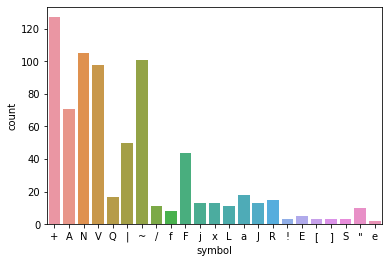

In [14]:
ax = sns.countplot(dataframe.symbol)

In [16]:
dataframe

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [17]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N'] 
    

In [18]:
# Classifying normal, abnormal or nonbeat
dataframe['category'] = -1
dataframe.loc[dataframe.symbol == 'N','category'] = 0
dataframe.loc[dataframe.symbol.isin(abnormal), 'category'] = 1    
      
dataframe.groupby('category').Counts.sum()

category
-1      8058
 0    196385
 1     90309
Name: Counts, dtype: int64

In [19]:
#removing the non-beat from dataframe
dataframe = dataframe.loc[~((dataframe['category']==-1))]
dataframe.groupby('category').Counts.sum()

category
0    196385
1     90309
Name: Counts, dtype: int64

In [20]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample
    

In [21]:
def build_XY(p_signal, df_ann, num_cols, normal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in normal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [22]:
# creating abnormal beat dataset
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal)]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all

In [23]:
# Parameter Values
num_sec = 1
fs = 360

X_abnormal, Y_abnormal, sym_abnormal = make_dataset(patients, num_sec, fs, abnormal)

## Normal ECG Data

In [24]:
data= '../input/mitbih-normal-sinus-rhythm-database/mit-bih-normal-sinus-rhythm-database-1.0.0/'

I chose two patients in order to have less computation time and less data.

In [25]:
patients = ["16265","16272"]

In [26]:
# creating normal beat dataset
def make_dataset(pts, num_sec, fs, normal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(normal)]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, normal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all

In [27]:
# Parameter Values
num_sec = 1
fs = 360

X_normal, Y_normal, sym_normal = make_dataset(patients, num_sec, fs, normal)

In [28]:
X_normal = X_normal[0:34376,:]

In [29]:
Y_normal = np.zeros((34376, 1))

In [30]:
X = np.append(X_normal,X_abnormal,axis=0)
Y = np.append(Y_normal,Y_abnormal,axis=0)
X = X[:,0:140]

In [31]:
raw_data= np.append(X, Y, axis=1)
raw_data = pd.DataFrame(raw_data)

# The last element contains the labels
labels = raw_data.iloc[: , -1]
labels= labels.values
# The other data points are the electrocadriogram data
data = raw_data.iloc[:, 0:-1]
data= data.values

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)


train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [33]:
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

val_df, test_df = train_test_split(
  test_data,
  test_size=0.2, 
  random_state=42)

In [34]:
test_labels =  ~test_labels

Plot a normal ECG.

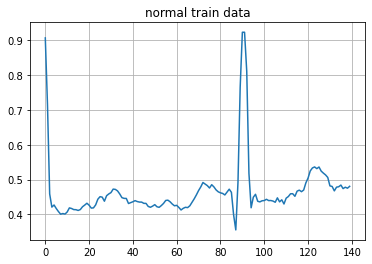

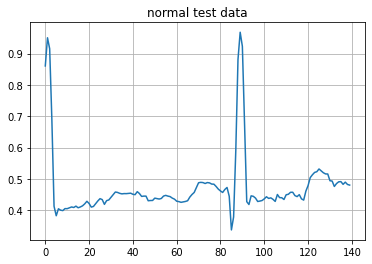

In [35]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("normal train data")
plt.show()

plt.grid()
plt.plot(np.arange(140), normal_test_data[543])
plt.title("normal test data")
plt.show()

Plot a abnormal ECG.

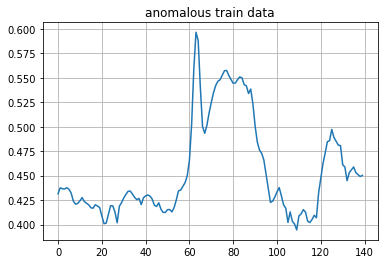

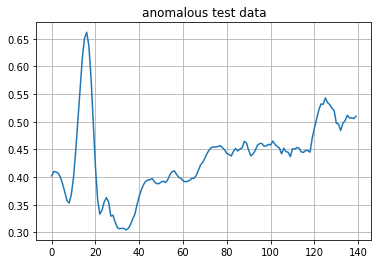

In [36]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("anomalous train data")
plt.show()

plt.grid()
plt.plot(np.arange(140), anomalous_test_data[0])
plt.title("anomalous test data")
plt.show()

#Build the model

In [37]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
])
    self.decoder = tf.keras.Sequential([

      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [38]:
autoencoder.compile("adam", loss="mean_absolute_error")

In [40]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=300, 
          batch_size=128,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/300
216/216 [==============================] - 2s 8ms/step - loss: 0.0170 - val_loss: 0.0184
Epoch 2/300
216/216 [==============================] - 2s 9ms/step - loss: 0.0171 - val_loss: 0.0181
Epoch 3/300
216/216 [==============================] - 2s 9ms/step - loss: 0.0170 - val_loss: 0.0177
Epoch 4/300
216/216 [==============================] - 2s 10ms/step - loss: 0.0170 - val_loss: 0.0186
Epoch 5/300
216/216 [==============================] - 2s 10ms/step - loss: 0.0171 - val_loss: 0.0180
Epoch 6/300
216/216 [==============================] - 2s 8ms/step - loss: 0.0171 - val_loss: 0.0196
Epoch 7/300
216/216 [==============================] - 2s 9ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 8/300
216/216 [==============================] - 2s 9ms/step - loss: 0.0170 - val_loss: 0.0182
Epoch 9/300
216/216 [==============================] - 2s 9ms/step - loss: 0.0171 - val_loss: 0.0185
Epoch 10/300
216/216 [==============================] - 2s 8ms/step - loss: 0.0170 - val_

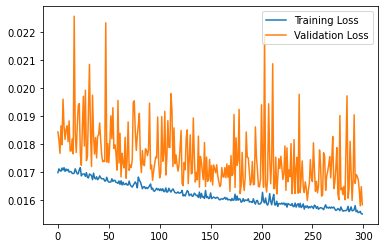

In [41]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

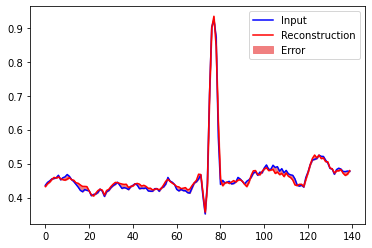

In [42]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# Anomaly Detection

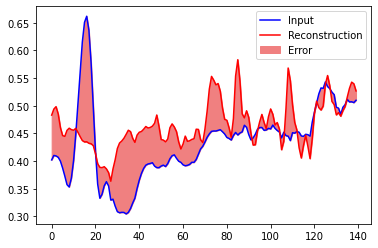

In [43]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

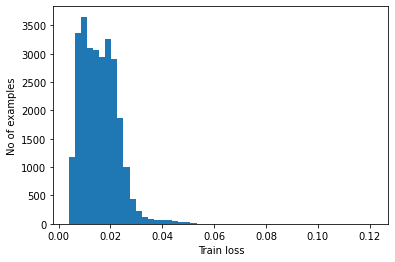

In [44]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [45]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.022963409373802594


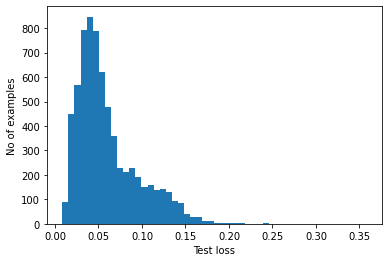

In [46]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [47]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
#test_data = test_data. numpy()

In [48]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8859719293142317
Precision = 0.9095134800123954
Recall = 0.8564341990078786


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


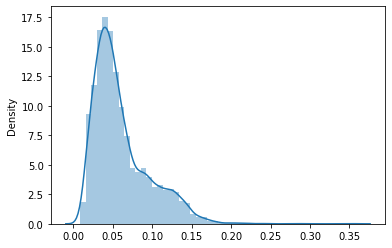

In [49]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
sns.distplot(train_loss, bins=50, kde=True);

In [50]:
reconstructions = autoencoder.predict(normal_test_data)
pred_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

pred_loss = pred_loss.numpy()
correct = sum(l <= threshold for l in pred_loss)
print(f'Correct normal predictions: {correct}/{len(normal_test_data)}')

Correct normal predictions: 5870/6854


In [51]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)
train_loss = train_loss.numpy()
correct = sum(l > threshold for l in train_loss)
print(f'Correct anomaly predictions: {correct}/{len(anomalous_test_data)}')

Correct anomaly predictions: 6313/6897


In [52]:
def plot_prediction_normal(i,data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
  
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*pred_loss[i], 2)})')
    ax.legend()

def plot_prediction_anomaly(i,data, model, title, ax):
    encoded_data = autoencoder.encoder(data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ax.axis([0, 140, 0, 1])
  
    ax.plot(data[i], label='true')
    ax.plot(decoded_data[i], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(1000*train_loss[i], 2)})')
    ax.legend()

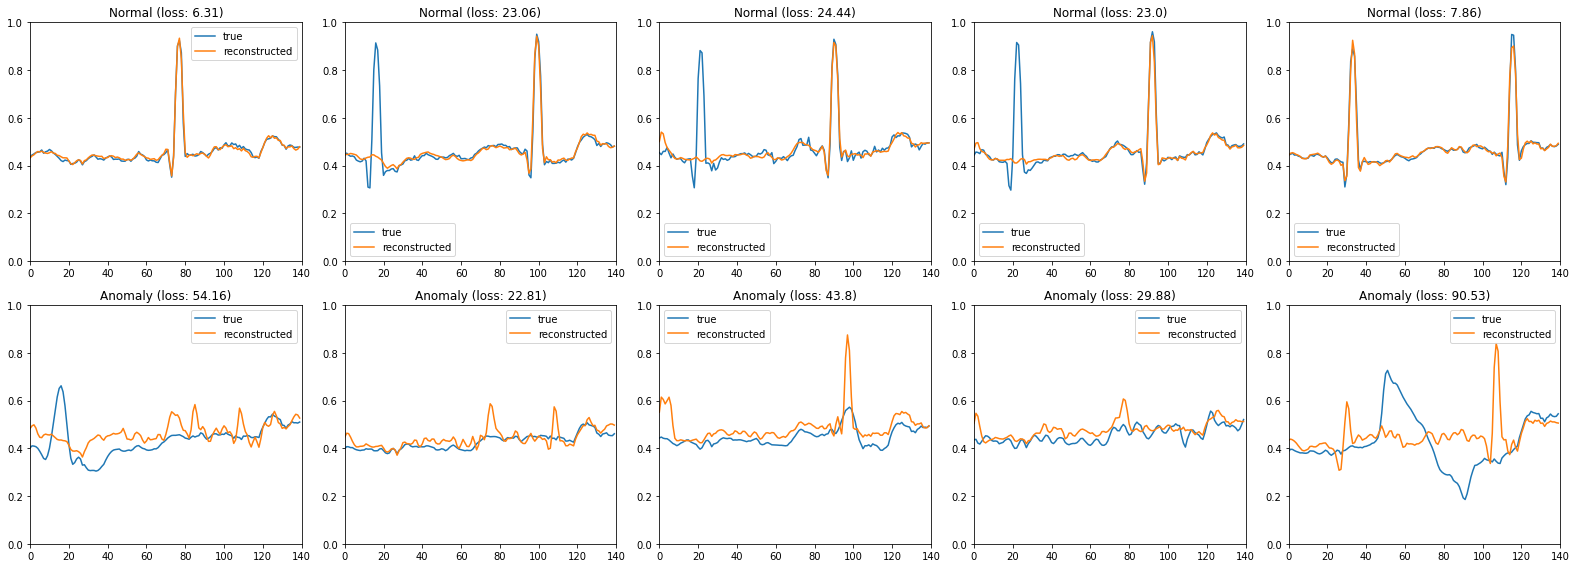

In [53]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=5,
  figsize=(22, 8)
)
for i in range(5) :
  plot_prediction_normal(i,normal_test_data, autoencoder, title='Normal', ax=axs[0, i])

for i in range(5) :
  plot_prediction_anomaly(i,anomalous_test_data, autoencoder, title='Anomaly', ax=axs[1, i])
fig.tight_layout();